<a href="https://colab.research.google.com/github/ZoliN/colab/blob/main/MODNet_Inference_with_onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODNet - Inference with onnx

This notebook is the modified version of the main [colab demo](https://colab.research.google.com/drive/1GANpbKT06aEFiW-Ssx0DQnnEADcXwQG6?usp=sharing#scrollTo=JOmYOHKfgQ5Y). Refer it for more information. 


In this demo, we provide a very high performance **inference ready onnx model** for image matting. It also supports dynamic input and output shapes. <b><font color='#00FF0'>The inference time is also very less and you don't need **GPU** to run it. </font></b>

## 1. Preparation

Clone the repository and download the pretrained model.

In [1]:
!pip install onnx onnxruntime
import os

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/manthan3C273/MODNet
%cd MODNet/

# dowload the onnx model for image matting
model = 'modnet.onnx'
if not os.path.exists(model):
  !gdown --id 1cgycTQlYXpTh26gB9FTnthE7AvruV8hd \
          -O pretrained/modnet.onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.5 MB/s eta 0:00:00
/content
Cloning into 'MODNet'...
remote: Enumerating objects: 165, done.
remote: Total 165 (delta 0), reused 0 (delta 0), pack-reused 165
Receiving objects: 100% (165/165), 37.60 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/MODNet
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cgycTQlYXpTh26gB9FTnthE7AvruV8hd
To: /content/MODNet/

## 2. Upload image

Upload portrait images to be processed (only PNG and JPG format are supported). 

Download demo image. Photo by Charlotte May from [Pexels](https://www.pexels.com/photo/unrecognizable-asian-woman-with-rucksack-in-town-5965592/)

In [2]:
# dowload image
image = 'image.jpg'
if not os.path.exists(image):
  !gdown --id 1fkyh03NEuSwvjFttYVwV7TjnJML04Xn6 \
          -O image.jpg

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fkyh03NEuSwvjFttYVwV7TjnJML04Xn6
To: /content/MODNet/image.jpg
100% 2.85M/2.85M [00:00<00:00, 173MB/s]


## 3. Inference

Run the following command for alpha matte prediction.

In [3]:
!python demo/image_matting/Inference_with_ONNX/inference_onnx.py \
        --image-path=image.jpg \
        --output-path=matte.png \
        --model-path=pretrained/modnet.onnx

## 4. Visualization

Display the results (from left to right: image, foreground, and alpha matte)

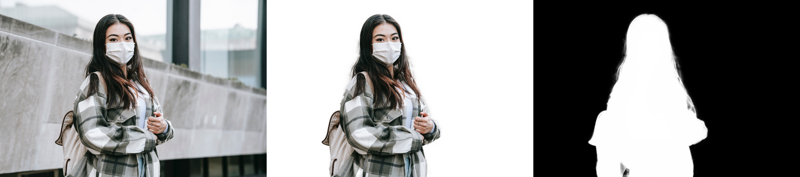

In [4]:
import numpy as np
from PIL import Image

def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined

# visualize all images

image = Image.open('image.jpg')
matte = Image.open('matte.png')
display(combined_display(image, matte))

## 5. Download image

Image with transparent background will be saved and downloaded. 

In [ ]:
image.putalpha(matte)
image.save('transparent_img.png')

from google.colab import files
files.download('transparent_img.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>